# TidyTuesday 2019-01-29

This is my take on TidyTuesday 2019 Week 5: **Dairy Production & Consumption in US**. In this notebook, I will try to estimate the price elasticity of demand for milk product using regression model.

## Problem Outline

Price elasticity of demand is a measurement of how much the decrease in the demanded quantity of a product if the price of that product is increased. In a simplified manners, we can write the elasticity as:

$$Price \space Elasticity \space of \space Demand = \frac{\Delta{Q}}{\Delta{P}}$$

Where:

- $\Delta{Q}$: Percentage change of demanded quantity
- $\Delta{P}$: Percentage change of price

Since the change of demanded quantity of a product is influenced by various factors, we can estimate the elasticity using a linear regression model as below:

$$log{Q}=\hat{\beta_{0}}+\hat{\beta_{1}}{log{P}}+\varepsilon$$

Log transformation in the model is crutial for the estimation; through log transformation, we can interpret the 1% increase in $P$ as $\hat{\beta_{1}}$% decrease in $Q$. Assuming that $\beta_{1}$ is negative, we can connect this model with price elasticity of demand formula as below:

$$Price \space Elasticity \space of \space Demand = -\beta_{1} = \frac{\Delta{Q}}{\Delta{P}}$$

## Codes

In this section, I will explain the step-by-step code and procedure used to estimate the elasticity.

### Environment setup

All of used modules and global settings are defined in the cell below:

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'figure.figsize': (8, 5),
    'figure.subplot.hspace': 0.5,
    'figure.titlesize': 'large',
    'axes.titlesize': 'medium',
    'axes.labelsize': 'small',
    'xtick.labelsize': 'xx-small',
    'ytick.labelsize': 'xx-small',
})

### Dataset

From this particular week's data, I will use the [`milkcow_facts.csv`](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-29/milkcow_facts.csv) data as the main dataset to estimate the elasticity. Let's take a quick look on the dataset:

In [2]:
data = pd.read_csv(os.path.join('..', 'data', 'processed', 'milkcow_facts.csv'))

data.head()

,year,avg_milk_cow_number,milk_per_cow,milk_production_lbs,avg_price_milk,dairy_ration,milk_feed_price_ratio,milk_cow_cost_per_animal,milk_volume_to_buy_cow_in_lbs,alfalfa_hay_price,slaughter_cow_price
0,1980.0,10799000.0,11891,1.284060e+11,0.130,0.048374,2.717149,1190,9153.846154,72.000000,0.4573
1,1981.0,10898000.0,12183,1.327700e+11,0.138,0.050352,2.759031,1200,8695.652174,70.900000,0.4193
2,1982.0,11011000.0,12306,1.355050e+11,0.136,0.044221,3.088127,1110,8161.764706,72.733333,0.3996
3,1983.0,11059000.0,12622,1.395880e+11,0.136,0.052350,2.609620,1030,7573.529412,78.700000,0.3935
4,1984.0,10793000.0,12541,1.353510e+11,0.135,0.053388,2.540000,895,6629.629630,79.483333,0.3981


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           35 non-null     float64
 1   avg_milk_cow_number            35 non-null     float64
 2   milk_per_cow                   35 non-null     int64  
 3   milk_production_lbs            35 non-null     float64
 4   avg_price_milk                 35 non-null     float64
 5   dairy_ration                   35 non-null     float64
 6   milk_feed_price_ratio          35 non-null     float64
 7   milk_cow_cost_per_animal       35 non-null     int64  
 8   milk_volume_to_buy_cow_in_lbs  35 non-null     float64
 9   alfalfa_hay_price              35 non-null     float64
 10  slaughter_cow_price            35 non-null     float64
dtypes: float64(9), int64(2)
memory usage: 3.1 KB


For price and quantity variables, we will use `avg_milk_cow_number` and `avg_price_milk`, respectively.

#### Data cleansing

There's not much room for data cleansing, since the data itself can be considered clean already. In this part, I will only change the data type of `year` variable for the sake of better visualizations in Exploratory Data Analysis (EDA) part.

In [4]:
data['year'] = data['year'].map(int)

data.head()

,year,avg_milk_cow_number,milk_per_cow,milk_production_lbs,avg_price_milk,dairy_ration,milk_feed_price_ratio,milk_cow_cost_per_animal,milk_volume_to_buy_cow_in_lbs,alfalfa_hay_price,slaughter_cow_price
0,1980,10799000.0,11891,1.284060e+11,0.130,0.048374,2.717149,1190,9153.846154,72.000000,0.4573
1,1981,10898000.0,12183,1.327700e+11,0.138,0.050352,2.759031,1200,8695.652174,70.900000,0.4193
2,1982,11011000.0,12306,1.355050e+11,0.136,0.044221,3.088127,1110,8161.764706,72.733333,0.3996
3,1983,11059000.0,12622,1.395880e+11,0.136,0.052350,2.609620,1030,7573.529412,78.700000,0.3935
4,1984,10793000.0,12541,1.353510e+11,0.135,0.053388,2.540000,895,6629.629630,79.483333,0.3981


### Exploratory Data Analysis

First of all, let's take a quick look on relation between `avg_milk_cow_number` and `avg_price_milk` in our sample:

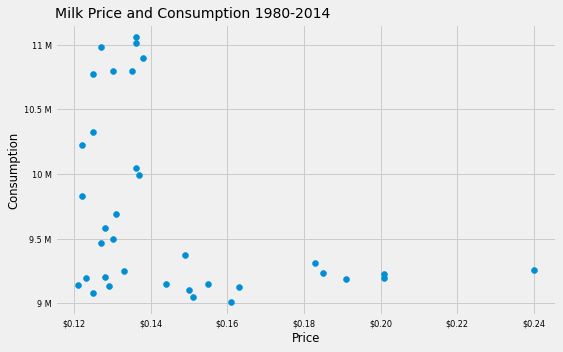

In [5]:
years = data['year'].tolist()
year_min = min(years)
year_max = max(years)


fig, ax = plt.subplots(1, 1)

ax.scatter(data['avg_price_milk'], data['avg_milk_cow_number'])
ax.set_xlabel('Price')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))
ax.set_ylabel('Consumption')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(f'Milk Price and Consumption {year_min}-{year_max}', loc='left')


plt.show()

From visualization above, we can slightly see that there is a negative correlation between `avg_milk_cow_number` and `avg_price_milk`.

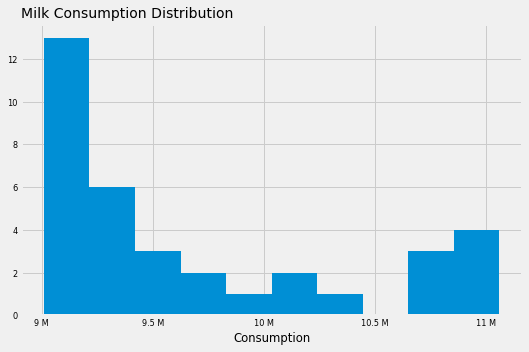

In [6]:
fig, ax = plt.subplots(1, 1)

ax.hist(data['avg_milk_cow_number'])
ax.set_xlabel('Consumption')
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title('Milk Consumption Distribution', loc='left')


plt.show()

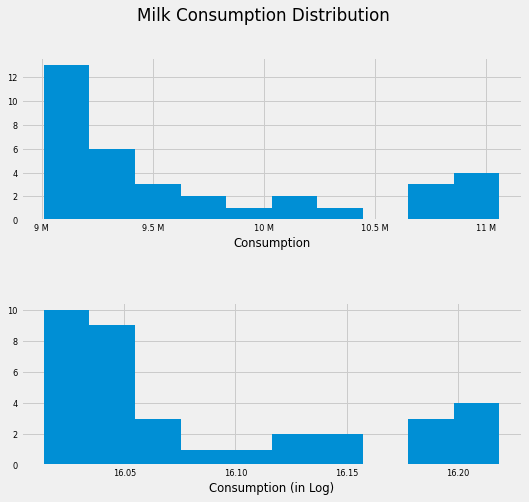

In [7]:
data_viz = data.copy()
data_viz['avg_milk_cow_number_ln'] = data_viz['avg_milk_cow_number'].map(lambda x: np.log(x))


fig, axs = plt.subplots(2, 1, figsize=(8, 7))

axs[0].hist(data['avg_milk_cow_number'])
axs[0].set_xlabel('Consumption')
axs[0].xaxis.set_major_formatter(ticker.EngFormatter())

axs[1].hist(data_viz['avg_milk_cow_number_ln'])
axs[1].set_xlabel('Consumption (in Log)')

fig.suptitle('Milk Consumption Distribution')


plt.show()

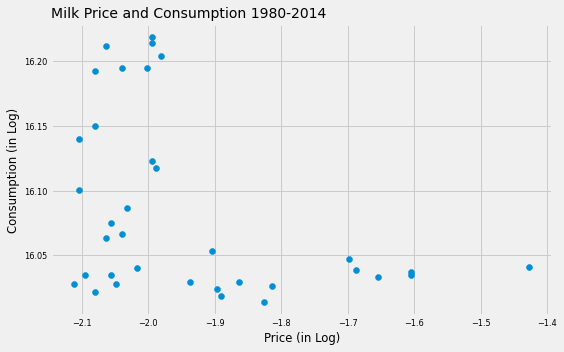

In [8]:
data_viz['avg_price_milk_ln'] = data_viz['avg_price_milk'].map(lambda x: np.log(x))


fig, ax = plt.subplots(1, 1)

ax.scatter(data_viz['avg_price_milk_ln'], data_viz['avg_milk_cow_number_ln'])
ax.set_xlabel('Price (in Log)')
ax.set_ylabel('Consumption (in Log)')
ax.set_title(f'Milk Price and Consumption {year_min}-{year_max}', loc='left')


plt.show()

### Model

#### Data Preprocess

In [9]:
data_train = data.copy()

data_train['avg_milk_cow_number_ln'] = data_train['avg_milk_cow_number'].map(lambda x: np.log(x))
data_train['avg_price_milk_ln'] = data_train['avg_price_milk'].map(lambda x: np.log(x))
data_train = data_train[['avg_milk_cow_number_ln', 'avg_price_milk_ln']]

data_train.head()

,avg_milk_cow_number_ln,avg_price_milk_ln
0,16.194964,-2.040221
1,16.204090,-1.980502
2,16.214405,-1.995100
3,16.218755,-1.995100
4,16.194408,-2.002481


In [10]:
x_columns = ['avg_price_milk_ln']
y_column = ['avg_milk_cow_number_ln']

x_train = sm.add_constant(data_train[x_columns])
y_train = data_train[y_column]

#### Model Fitting

In [11]:
model = sm.OLS(y_train, x_train).fit()
model_coefs = dict(model.params)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     avg_milk_cow_number_ln   R-squared:                       0.157
Model:                                OLS   Adj. R-squared:                  0.131
Method:                     Least Squares   F-statistic:                     6.130
Date:                    Sun, 27 Mar 2022   Prob (F-statistic):             0.0186
Time:                            12:47:18   Log-Likelihood:                 46.981
No. Observations:                      35   AIC:                            -89.96
Df Residuals:                          33   BIC:                            -86.85
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                15.7751      0.126    125.641      0.000      15.520      16.031
avg_price_milk_ln    -0.1598      0.065     -2.476      0.019      -0.291      -0.028
==============================================================================
Omnibus:                        3.882   Durbin-Watson:                   0.166
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.115
Skew:                           0.612   Prob(JB):                        0.211
Kurtosis:                       2.201   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model Evaluation

In [12]:
y_train_pred = model.predict(x_train)


error = mean_squared_error(np.exp(y_train), np.exp(y_train_pred), squared=False)

error

632009.241076186

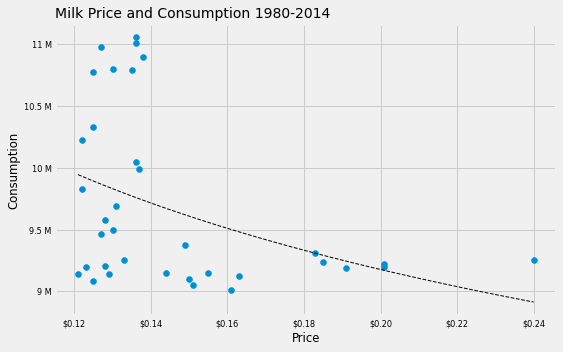

In [13]:
xseq = np.linspace(
    start=data_train['avg_price_milk_ln'].min(),
    stop=data_train['avg_price_milk_ln'].max(),
    num=100,
)

fig, ax = plt.subplots(1, 1)

ax.scatter(data['avg_price_milk'], data['avg_milk_cow_number'])
ax.plot(
    np.exp(xseq),
    np.exp(model_coefs['const'] + model_coefs['avg_price_milk_ln'] * xseq),
    color='black',
    linewidth=1,
    linestyle='dashed',
)
ax.set_xlabel('Price')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.2f}'))
ax.set_ylabel('Consumption')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(f'Milk Price and Consumption {year_min}-{year_max}', loc='left')


plt.show()